In [1]:
# load MNIST dataset

from sklearn.datasets import fetch_openml

X, y = fetch_openml( 'mnist_784', version=1, return_X_y=True )

X = X.values

y = y.astype(int).values

In [2]:
# print dimensions of arrays

print(X.shape)

print(y.shape)

(70000, 784)
(70000,)


In [3]:
# Normalize pixel values

X = ((X / 255.)) * 2

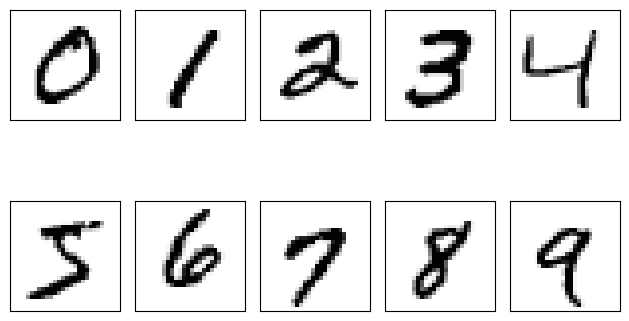

In [4]:
# Visualize examples of digits

import matplotlib.pyplot as plt

fig, ax = plt.subplots( nrows=2, ncols=5, sharex=True, sharey=True )

ax = ax.flatten()

for i in range(10):
    img = X[y == i][0].reshape( 28, 28)

    ax[i].imshow( img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

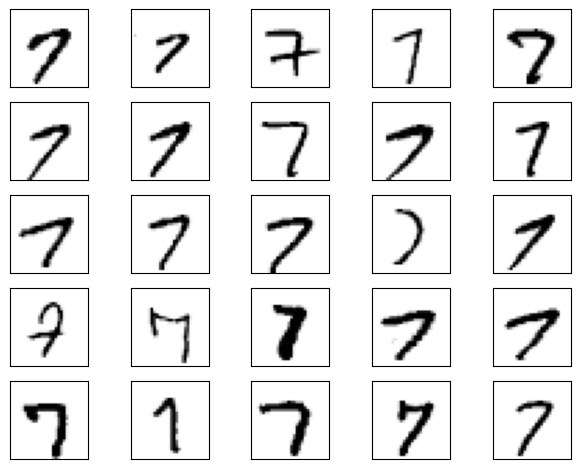

In [5]:
# print multiple examples

fig, ax = plt.subplots( nrows=5, ncols=5, sharex=True, sharey=True )

ax = ax.flatten()

for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [6]:
# split data into training, validation, and test subsets

from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split( X, y, test_size=10000, random_state=123, stratify=y )

X_train, X_valid, y_train, y_valid = train_test_split( X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

In [7]:
# helper functions
# 1. sigmoid function
# 2. one-hot encode labels

import numpy as np

def sigmoid(z):
    return 1. / ( 1 + np.exp(-z) )

def int_to_onehot( y, num_labels ):
    
    ary = np.zeros(( y.shape[0], num_labels ))

    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

In [8]:
# main class for MLP w/ methods __init__, forward, backward

class NerualNetMLP:
    
    def __init__( self, num_features, num_hidden, num_classes, random_seed=123):
        
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState( random_seed )

        self.weight_h = rng.normal( loc=0.0, scale=0.1, size=(num_hidden, num_features) )
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal( loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros( num_classes )

    def forward( self, x ):
        
        # hidden layer
        z_h = np.dot( x, self.weight_h.T) + self.bias_h
        a_h = sigmoid( z_h )

        # output layer
        z_out = np.dot( a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid( z_out )

        return a_h, a_out
    
    def backward( self, x, a_h, a_out, y):
        ########################
        ### output layer weights
        ########################

        # one-hot encoding
        y_onehot = int_to_onehot( y, self.num_classes )

        # part 1: dLos/dOutWeights

        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        d_a_out__d_z_out = a_out * (1. - a_out ) #sigmoid derivative

        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        #gradient for output weights

        d_z_out__dw_out = a_h

        d_loss__dw_out = np.dot( delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum( delta_out, axis=0 )

        # part 2: dLoss/dHiddenWeights

        d_z_out__a_h = self.weight_out

        d_loss__a_h = np.dot(delta_out, d_z_out__a_h )
        
        d_a_h__d_z_h = a_h * ( 1. - a_h ) # sigmoid derivative

        d_z_h__d_w_h = x

        d_loss__d_w_h = np.dot(( d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum(( d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h )

In [9]:
model = NerualNetMLP( num_features=28*28, num_hidden=50, num_classes=10)

In [10]:
# divide dataset into mini-batches for stochastic gradient descent

import numpy as np
num_epochs = 50
minibatch_size = 100

def minibatch_generator( X, y, minibatch_size):
    indices = np.arange( X.shape[0])
    np.random.shuffle( indices )

    for start_idx in range( 0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

In [17]:
# test minibatch code from above

# iterate over training epochs
for i in range(num_epochs):
    # iterate over minibatches

    minibatch_gen = minibatch_generator( X_train, y_train, minibatch_size )

    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [18]:
# define loss function and performance metric
# for loss use MSE 

def mse_loss( targets, probas, num_labels=10):
    onehot_targets = int_to_onehot( targets, num_labels=num_labels)

    return np.mean( ( onehot_targets - probas ) ** 2)

def accuracy(targets, predicted_labels):
    return np.mean( predicted_labels == targets)

In [19]:
# test previous functions and compute initial validation MSE and accuracy

_, probas = model.forward( X_valid )
mse = mse_loss( y_valid, probas )
print(f'Initial validation MSE: {mse:.1f}')

predicted_labels = np.argmax( probas, axis=1)
acc = accuracy( y_valid, predicted_labels )
print(f'Initial Validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.2
Initial Validation accuracy: 10.2%


In [20]:
# compute MSE and accuracy by iterating over dataset one mini-batch at a time to be more memory efficient

def compute_mse_and_acc( nnet, X, y, num_labels=10, minibatch_size=100 ):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator( X, y, minibatch_size)
    for i, (features, targets) in enumerate( minibatch_gen ):
        _, probas = nnet.forward( features )
        predicted_labels = np.argmax( probas, axis=1 )
        onehot_targets = int_to_onehot( targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += ( predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    
    mse = mse/i
    acc = correct_pred / num_examples

    return mse, acc

In [21]:
# test previous function for mse and accuracy

mse, acc = compute_mse_and_acc( model, X_valid, y_valid )

print(f'Initial valid MSE: {mse:.1f}')

print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 10.2%


In [22]:
# implement code to train model
def train( model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1 ):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range( num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator( X_train, y_train, minibatch_size )
        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward( X_train_mini )

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, \
            d_loss__d_w_h,   d_loss__d_b_h   = model.backward( X_train_mini, a_h, a_out, y_train_mini )

            #### Update weights ####
            model.weight_h   -= learning_rate * d_loss__d_w_h
            model.bias_h     -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out   -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc( model, X_train, y_train )
        valid_mse, valid_acc = compute_mse_and_acc( model, X_valid, y_valid )

        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        
        epoch_train_acc.append( train_acc )
        epoch_valid_acc.append( valid_acc )
        epoch_loss.append( train_mse )

        print(f'Epoch: {e+1:03d}/{num_epochs:03d} | Train MSE: {train_mse:.2f} | Train Acc: {train_acc:.2f}% | Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [23]:
# train model with 50 epochs
np.random.seed(123)

epoch_loss, epoch_train_acc, epoch_valid_acc = train( model, X_train, y_train, X_valid, y_valid, num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 77.23% | Valid Acc: 76.68%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 86.10% | Valid Acc: 85.50%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 88.31% | Valid Acc: 87.88%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.53% | Valid Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.25% | Valid Acc: 89.98%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.80% | Valid Acc: 90.74%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.28% | Valid Acc: 91.04%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.65% | Valid Acc: 91.32%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 92.05% | Valid Acc: 91.70%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.29% | Valid Acc: 92.08%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.60% | Valid Acc: 92.24%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.77% | Valid Acc: 92.44%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.99% | Valid Acc: 92.54%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 93.16

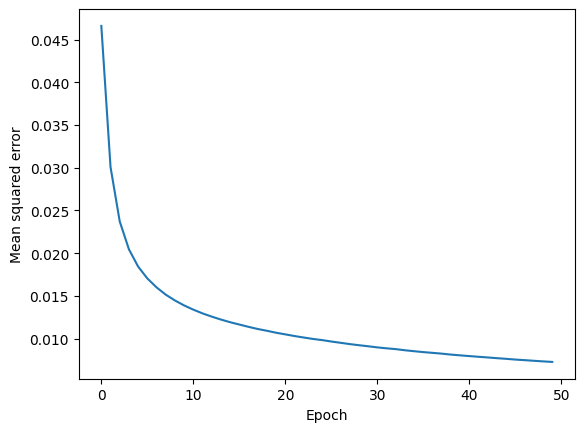

In [24]:
# plot MSE loss for previous NN
plt.plot( range( len( epoch_loss)), epoch_loss )
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

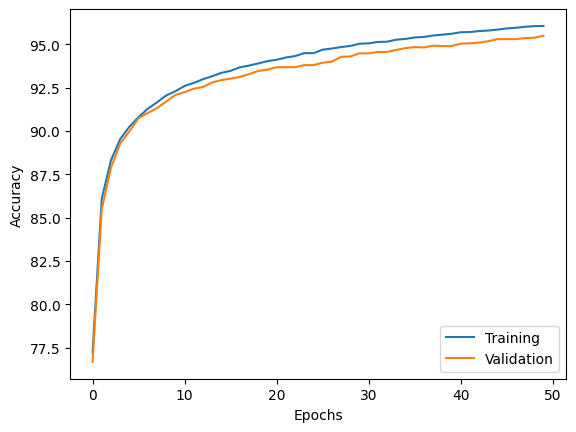

In [25]:
# plot training and validation accuracy
plt.plot( range( len( epoch_train_acc ) ), epoch_train_acc, label='Training')
plt.plot( range( len( epoch_valid_acc ) ), epoch_valid_acc, label='Validation' )

plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend( loc='lower right' )

plt.show

In [26]:
# generalization performance
test_mse, test_acc = compute_mse_and_acc( model, X_test, y_test )
print(f'Test accuracy: {test_acc*100:.2f}%')


Test accuracy: 95.04%


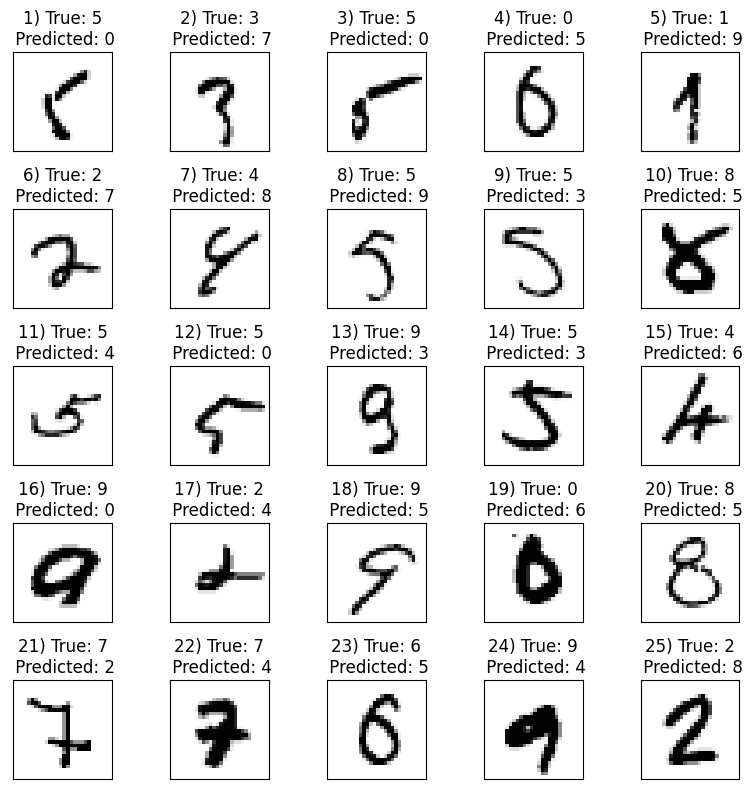

In [28]:
# plot images MLP struggles to predict correctly

X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward( X_test_subset )
test_pred = np.argmax( probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots( nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))

ax = ax.flatten()

for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) True: {correct_labels[i]}\n Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

plt.show()